## Quick Start

In [2]:
%matplotlib inline 
from pycotools import model, models, viz, tasks, misc
import os
import pandas

/home/b3053674/anaconda2/lib/python2.7/site-packages/pycotools/viz.py:117: FutureWarning: The pandas.parser module is deprecated and will be removed in a future version. Please import from pandas.io.parser instead
  from pandas.parser import CParserError


### Create Michaelis-Menten Model

In [119]:
working_directory = r'/home/b3053674/Documents/Models/2018/01_Jan/PyCoToolsQuickStart'
copasi_file = os.path.join(working_directory, 'quick_start_model.cps')

if os.path.isfile(copasi_file):
    os.remove(copasi_file)

    
kf = 0.1
kb = 1
kcat = 0.3
E = 75
S = 1000
with model.Build(copasi_file) as m:
    m.name = 'Michaelis-Menten'
    
    ## Prespecification of compartment and metabolites is not necessary as defaults are automaticlly created
    ## Here we be explicit to directly specify specie concentrations
    m.add('compartment', name='Cell')
    
    m.add('metabolite', name='P', concentration=0)
    m.add('metabolite', name='S', concentration=S)
    m.add('metabolite', name='E', concentration=E)
    m.add('metabolite', name='ES', concentration=0)
    
    ## type of reaction component are inferred from the expression
    ## For example, here S and E are substrates, ES is product and kf is parameter. 
    ## The reaction has no modifiers. Note, expression has the same syntax as copasi GUI
    m.add('reaction', name='S bind E', 
          expression='S + E -> ES', 
          rate_law='kf*S*E',
          parameter_values={'kf': kf})
    
    m.add('reaction', name='S unbind E', 
          expression='ES -> S + E', 
          rate_law='kb*ES',
         parameter_values={'kb': kb})

    m.add('reaction', name='ES produce P', 
          expression='ES -> P + E',
          rate_law='kcat*ES', 
          parameter_values={'kcat': kcat})
    
michaelis_menten = model.Model(copasi_file)

michaelis_menten

print('km = {}'.format((float(kb)+kcat)/kf))
print('vmax = kcat * Etot = {}'.format(kcat* E))

km = 13.0
vmax = kcat * Etot = 22.5


### Simulate Michaelis-Menten model

In [120]:
TC = tasks.TimeCourse(michaelis_menten, end=100, 
                      step_size=1, intervals=100, 
                      report_name='MM-time-course.csv')

### Plot results

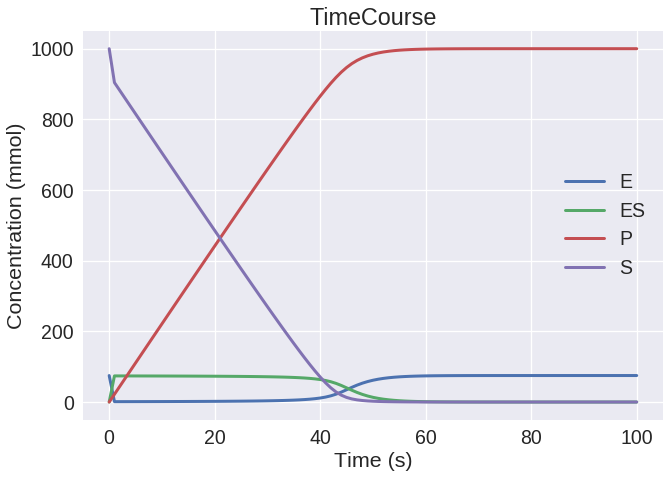

In [121]:
## all on one graph
viz.PlotTimeCourse(TC, separate=False)

plotting "E" on the x axis


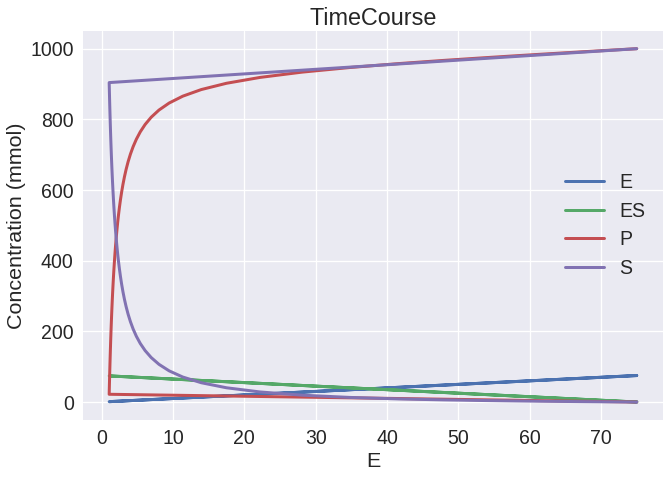

In [122]:
## Get metabolite names
metabolite_names = [i.name for i in michaelis_menten.metabolites]

## get the first in the list
metab = metabolite_names[0]

print('plotting "{}" on the x axis'.format(metab))

## plot in phase space by specifying x and y parameters
viz.PlotTimeCourse(TC, x=metab, separate=False)

### Inspect the model

In [123]:
print('model has {} metabolites, {} reactions and {} local parameters'.format(
    len(michaelis_menten.metabolites),
    len(michaelis_menten.reactions),
    len(michaelis_menten.local_parameters)
)
     )


model has 4 metabolites, 3 reactions and 3 local parameters


### Prepare Time Course Results for Parameter Estimation
Since copasi headers from copasi output looks like this:

In [124]:
pandas.read_csv(TC.report_name, sep='\t').head()## i.e. species names are enclosed in '[]'

,Time,[E],[ES],[P],[S]
0,0,75.00000,0.0000,0.0000,1000.000
1,1,1.06285,73.9372,21.9577,904.105
2,2,1.08914,73.9109,44.1349,881.954
3,3,1.11675,73.8832,66.3041,859.813
4,4,1.14579,73.8542,88.4647,837.681


And we need exact match between variable names and data file headers, we can use the `misc.correct_copasi_timecourse_headers` function to automatically format the simulated time course data for us

In [125]:
## Note this overwrites the data file and returns a df. 
misc.correct_copasi_timecourse_headers(TC.report_name).head()

,Time,E,ES,P,S
0,0,75.00000,0.0000,0.0000,1000.000
1,1,1.06285,73.9372,21.9577,904.105
2,2,1.08914,73.9109,44.1349,881.954
3,3,1.11675,73.8832,66.3041,859.813
4,4,1.14579,73.8542,88.4647,837.681


### Do parameter estimations
Spread computation over multiple model copies. Use an appropriate `copy_number` for your computers capabilities. Monitor task manager or system monitor to see CopasiSE tasks in operation.

In [126]:
PE = tasks.MultiParameterEstimation(michaelis_menten, TC.report_name, method='genetic_algorithm_sr', 
                                   copy_number=3, pe_number=20, population_size=50, 
                                   number_of_generations=100, metabolites=[], overwrite_config_file=True)
PE.write_config_file()
PE.setup()
PE.run()

print('PE results will go to {}'.format(PE.results_directory))

pycotools.tasks:DEBUG:602:    running Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)
pycotools.tasks:DEBUG:602:    running Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)
pycotools.tasks:DEBUG:602:    running Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)
PE results will go to /home/b3053674/Documents/Models/2018/01_Jan/PyCoToolsQuickStart/MultipleParameterEstimationResults


### Visualize data

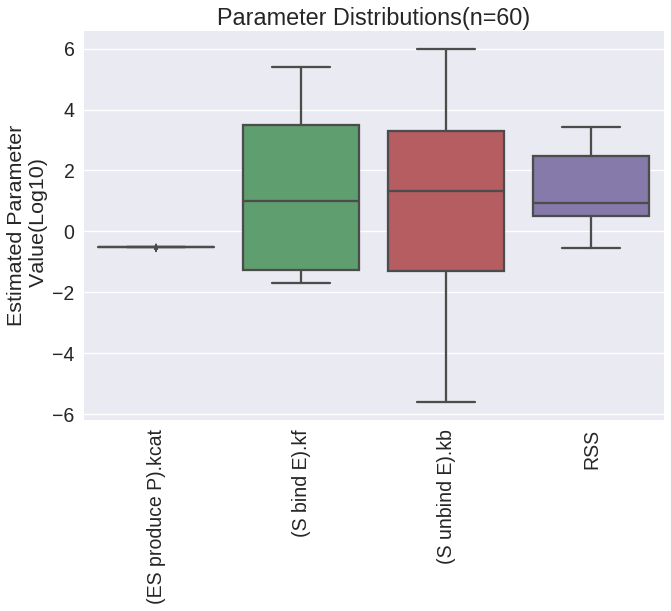

In [127]:
## boxplot all data
viz.Boxplots(PE, log10=True, num_per_plot=8)

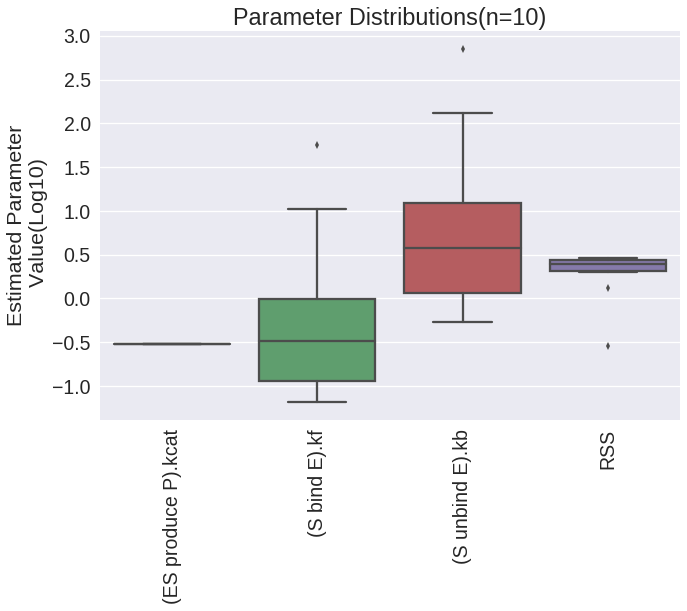

In [128]:
## box plot top 10 results
viz.Boxplots(PE, log10=True, num_per_plot=8, truncate_mode='ranks', theta=range(10))

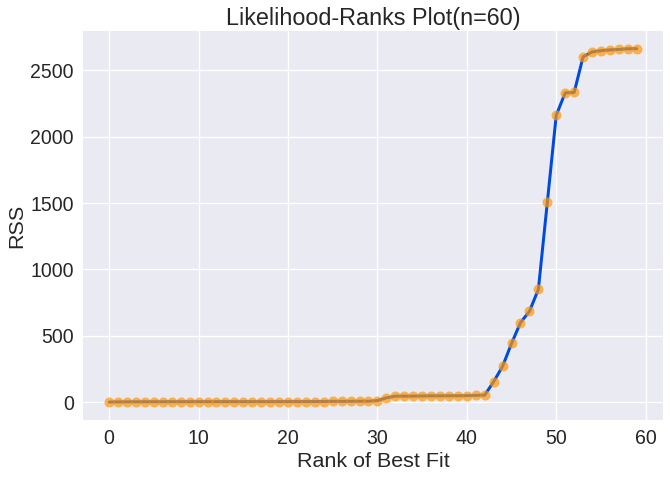

In [129]:
## Evaluate performance of optimization problem with likelihood-ranks plot
viz.LikelihoodRanks(PE, log10=False)

pycotools.viz:DEBUG:1390:    tpe self.cls parse --> MultiParameterEstimation(copy_number="3", pe_number="20", method="genetic_algorithm_sr")
pycotools.viz:INFO:1517:    Plotting "E"
pycotools.viz:INFO:1517:    Plotting "ES"
pycotools.viz:INFO:1517:    Plotting "P"
pycotools.viz:INFO:1517:    Plotting "S"


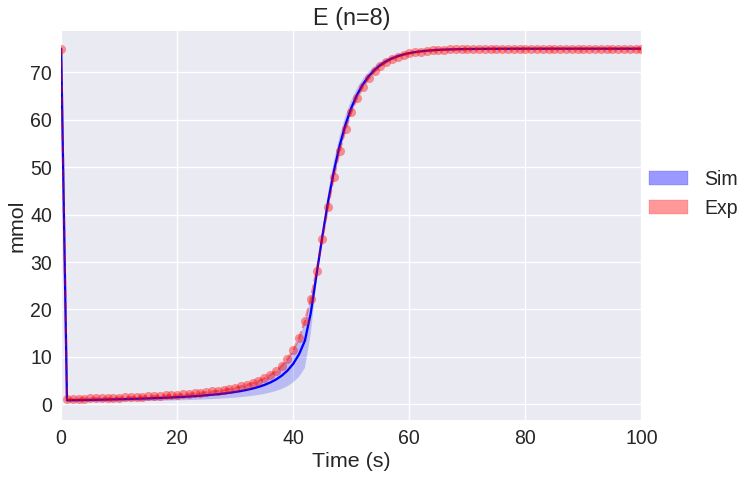

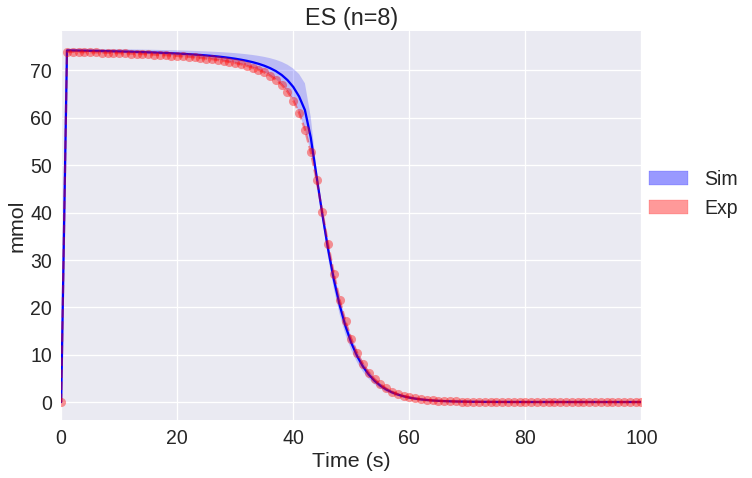

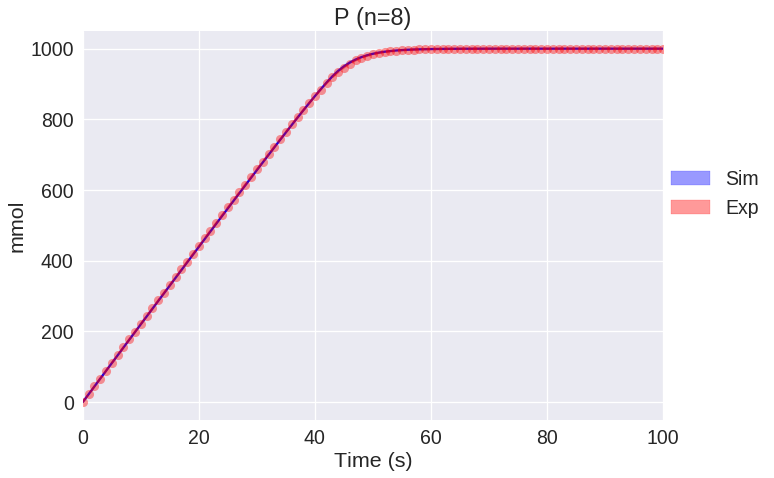

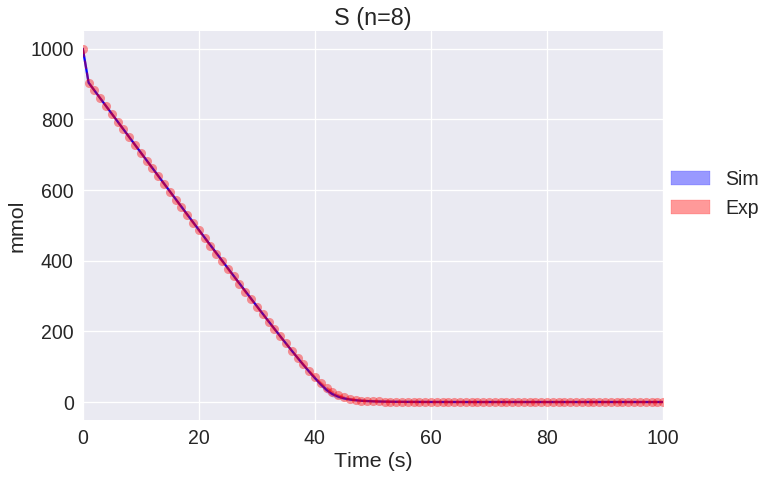

In [130]:
## visualize uncertainty in model predictions introduced by parameter sets
viz.PlotTimeCourseEnsemble(PE, truncate_mode='ranks', theta=[0, 5, 10, 20, 30, 40, 50, 59])
## Note that the fits are quite good as a result of this being synthetic data

pycotools.viz:INFO:2570:    Plotting "(S unbind E).kb" Vs "(ES produce P).kcat"
pycotools.viz:INFO:2570:    Plotting "(S unbind E).kb" Vs "(S bind E).kf"
pycotools.viz:INFO:2570:    Plotting "(S unbind E).kb" Vs "(S unbind E).kb"
pycotools.viz:INFO:2570:    Plotting "(S unbind E).kb" Vs "RSS"


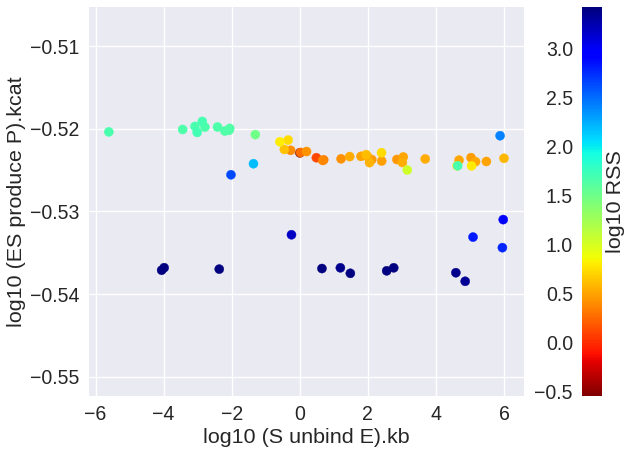

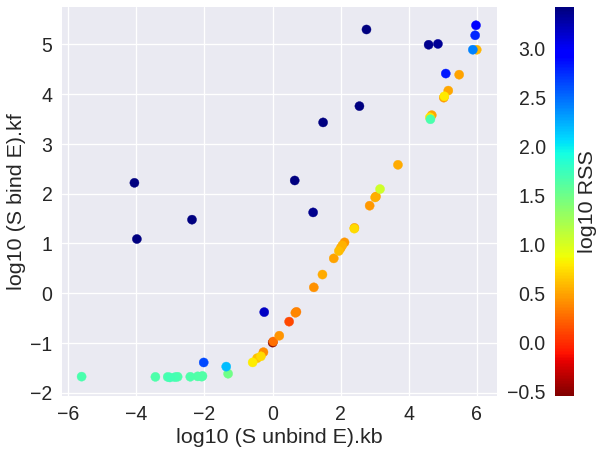

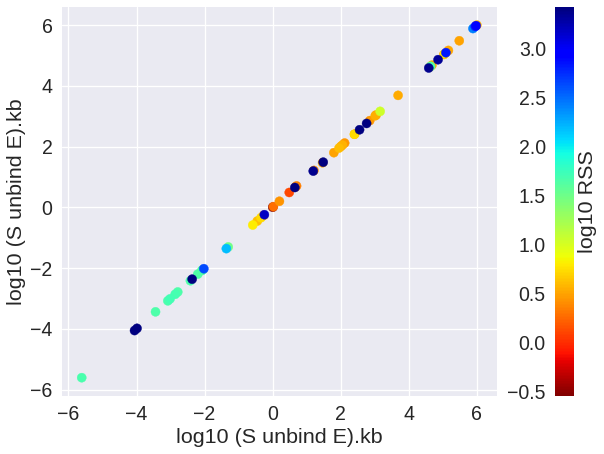

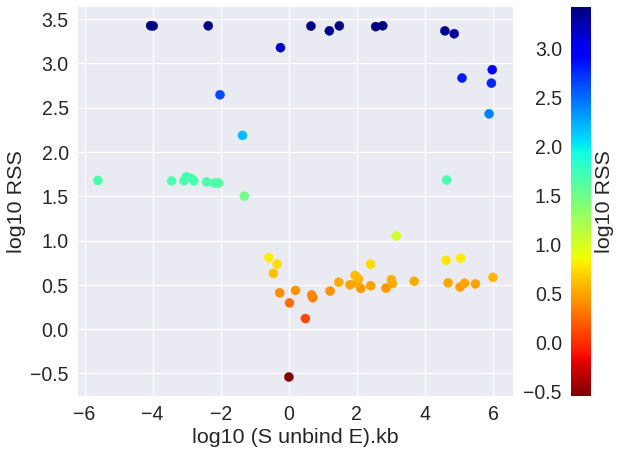

In [131]:
## Plot all combinations of parameter
viz.Scatters(PE, x=['(S unbind E).kb'], y='all', log10=True)

### Profile Likelihoods

In [132]:
PL = tasks.ProfileLikelihood(michaelis_menten, parameter_path=PE.results_directory, index=0, run=True,
                            max_active=4, number_of_steps=10, log10=True)

print(PL.results_directory)

pycotools.tasks:INFO:4866:    running /home/b3053674/Documents/Models/2018/01_Jan/PyCoToolsQuickStart/ProfileLikelihoods/0/(S bind E).kf.cps
pycotools.tasks:INFO:4866:    running /home/b3053674/Documents/Models/2018/01_Jan/PyCoToolsQuickStart/ProfileLikelihoods/0/(ES produce P).kcat.cps
pycotools.tasks:INFO:4866:    running /home/b3053674/Documents/Models/2018/01_Jan/PyCoToolsQuickStart/ProfileLikelihoods/0/(S unbind E).kb.cps
/home/b3053674/Documents/Models/2018/01_Jan/PyCoToolsQuickStart/ProfileLikelihoods


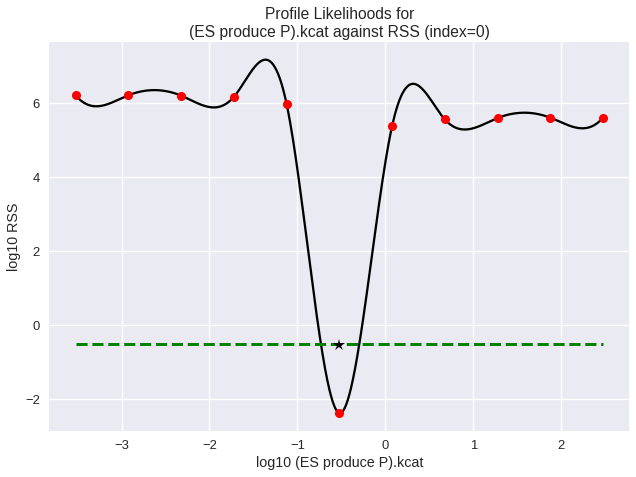

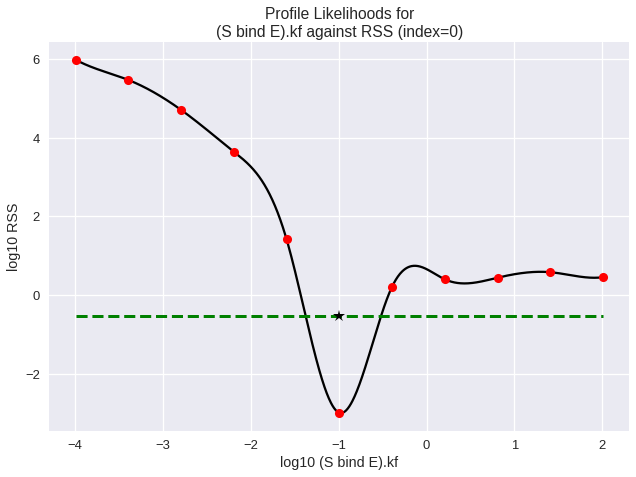

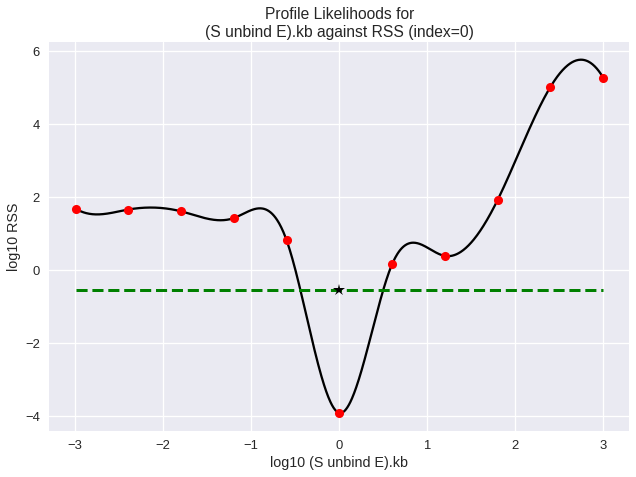

In [134]:
viz.PlotProfileLikelihood(PL, interpolation='cubic', log10=True)

### Best Parameters
original parameters:
* kcat: 0.3
* kf: 0.1
* kb: 1


Best estimated parameters:

In [136]:
viz.Parse(PE).data.iloc[0]

(ES produce P).kcat    0.299970
(S bind E).kf          0.101912
(S unbind E).kb        1.007950
RSS                    0.288222
Name: 0, dtype: float64